In [105]:
pip install python-graphblas[default]

Активация библиотек:

In [106]:
import graphblas as gb

gb.init("suitesparse", blocking=False)

from graphblas import Matrix, dtypes, unary, binary, monoid, semiring, Recorder
from graphblas.io import mmread
from scipy.sparse import coo_matrix
import numpy as np

import os

Рассмотрим матрицу M:

In [107]:
M = mmread('karate.mtx')
M

"M_4525740"  nvals  nrows  ncols  dtype     format
gb.Matrix      156     34     34   FP64  csr (iso)
--------------------------------------------------
     0    1    2    3    4    5    6    7    8    9   ...   24   25   26   27  \
0        1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0       ...                       
1   1.0       1.0  1.0                 1.0            ...                       
2   1.0  1.0       1.0                 1.0  1.0  1.0  ...                 1.0   
3   1.0  1.0  1.0                      1.0            ...                       
4   1.0                           1.0                 ...                       
5   1.0                           1.0                 ...                       
6   1.0                 1.0  1.0                      ...                       
7   1.0  1.0  1.0  1.0                                ...                       
8   1.0       1.0                                     ...                       
9             1.0                                     ...                       
10  1.0                 1.0  1.0                      ...                       
11  1.0                                               ...                       
12  1.0            1.0                                ...                       
13  1.0  1.0  1.0  1.0                                ...                       
14                                                    ...                       
15                                                    ...                       
16                           1.0  1.0                 ...                       
17  1.0  1.0                                          ...                       
18                                                    ...                       
19  1.0  1.0                                          ...                       
20                                                    ...                       
21  1.0  1.0                                          ...                       
22                                                    ...                       
23                                                    ...       1.0       1.0   
24                                                    ...       1.0       1.0   
25                                                    ...  1.0                  
26                                                    ...                       
27            1.0                                     ...  1.0                  
28            1.0                                     ...                       
29                                                    ...            1.0        
30       1.0                                1.0       ...                       
31  1.0                                               ...  1.0  1.0             
32            1.0                           1.0       ...                       
33                                          1.0  1.0  ...            1.0  1.0   

     28   29   30   31   32   33  
0                  1.0            
1             1.0                 
2   1.0                 1.0       
3                                 
4                                 
5                                 
6                                 
7                                 
8             1.0       1.0  1.0  
9                            1.0  
10                                
11                                
12                                
13                           1.0  
14                      1.0  1.0  
15                      1.0  1.0  
16                                
17                                
18                      1.0  1.0  
19                           1.0  
20                      1.0  1.0  
21                                
22                      1.0  1.0  
23       1.0            1.0  1.0  
24                 1.0            
25                 1.0            
26       1.0                 1.0  
27                           1.

Визуализируем граф:

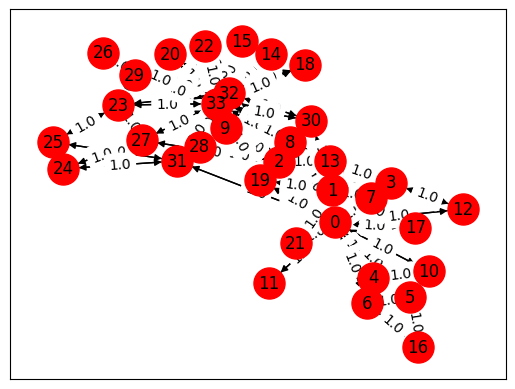

In [108]:
gb.viz.draw(M)

Используя python-graphblas реализовать **наивный алгоритм**, для матрицы смежности *A* вычисляющий *Aⁿ*, где *n=3*, и возвращающий количество треугольников неориентированного графа:

In [109]:
def naiveA3(A):
    # Вычислим A**3:
    TRI = A.mxm(A).mxm(A)

    # Извлекаем диагонал из матрицы, суммируем по элементам:
    tri2 = int(TRI.diag().reduce(gb.agg.sum).value or 0)

    # Число треугольников считаем для каждой вершины + граф неориентированный => 3*2 = 6:
    cnt_triangle = tri2 / 6

    return cnt_triangle

Используя python-graphblas реализовать **наивный алгоритм с маской**, для матрицы смежности *A* вычисляющий *Aⁿ*, где *n=2* и возвращающий количество треугольников неориентированного графа:

In [110]:
def naiveMaskA2(A):
    # Вычислим A**2:
    A2 = A.mxm(A)

    # Используем A как маску:
    mask_A = A.dup(dtype=dtypes.BOOL)

    # Используем A как маску для матрицы A2:
    TRI_A = A2.dup(mask=mask_A)

    # Просуммируем элементы TRI_A:
    tri2 = int(TRI_A.reduce_scalar(gb.monoid.plus).value or 0)

    # Число треугольников считаем для каждой вершины + граф неориентированный => 3*2 = 6:
    cnt_triangle = tri2 / 6

    return cnt_triangle

Используя python-graphblas реализовать **Сohen's algorithm**, вычисляющий количество треугольников неориентированного графа:

In [111]:
def cohen(A):
    #Разбиваем матрицу A на верхнетреугольную L и нижнетреугольную U:
    L = gb.select.tril(A)
    U = gb.select.triu(A)

    # Используем A как маску:
    mask_A = A.dup(dtype=dtypes.BOOL)

    # Посчитать матрицу B:
    B = L.mxm(U)

    # Используем A как маску для матрицы B:
    C = B.dup(mask=mask_A)

    # Просуммируем элементы С и поделим на 2, так как каждый трегольник будет посчитан дважды:
    cnt_triangle = int(C.reduce_scalar(gb.monoid.plus).value or 0) / 2

    return cnt_triangle

Используя python-graphblas реализовать **Sandia algorithm**, вычисляющий количество треугольников неориентированного графа:

In [112]:
def sandia(A):
    #Разбиваем матрицу A на верхнетреугольную L:
    L = gb.select.tril(A)

    # Используем L как маску:
    mask_A = L.dup(dtype=dtypes.BOOL)

    # Умножим матрицу L на L с использованием маски L:
    С = L.mxm(L).dup(mask=mask_A)

    # Просуммируем элементы, каждый трегольник будет посчитан единожды:
    cnt_triangle = С.reduce_scalar(gb.monoid.plus).value or 0

    return cnt_triangle

In [113]:
def test(A):
    result = [naiveA3(A), naiveMaskA2(A), cohen(A), sandia(A)]
    print(result)
    if not all(element == element for element in result):
       print("All return values are not equal")
    else:
        %timeit naiveA3(A)
        %timeit naiveMaskA2(A)
        %timeit cohen(A)
        %timeit sandia(A)

Результаты + время выполнения каждой из функций:

In [114]:
test(M)

[45.0, 45.0, 45.0, 45.0]
575 µs ± 205 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
The slowest run took 4.05 times longer than the fastest. This could mean that an intermediate result is being cached.
365 µs ± 192 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
311 µs ± 6.56 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
213 µs ± 12.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


*(+2 балла)* Используя python-graphblas реализовать функцию, вычисляющую для каждой вершины неориентированного графа количество треугольников, в которых она участвует.

In [115]:
def GetCntTr(A):

    # Используем A как маску:
    mask_A = A.dup(dtype=dtypes.BOOL)

    # Вычислим произведение A на себя + маска для ограничения результата умножения + сумма по столбцам
    # Находим все треугольники, в которых участвует рассматриваемая вершина:
    # Делим на 2, так как каждый трегольник будет посчитан дважды:
    cnt_triangle = (A.mxm(A).dup(mask=mask_A).reduce_columnwise(gb.monoid.plus)) / 2

    # Чтобы не потерять вершины без треугольников:
    # Количество вершин:
    rows = A.nrows
    lost_ind = set(range(rows)).difference(set(cnt_triangle))
    # Устанавливаем значение для таких вершин:
    for i in lost_ind:
        cnt_triangle[i] << 0

    return cnt_triangle

In [116]:
GetCntTr(M)

gb.VectorExpression                            size  dtype
v_365587.apply(binary.truediv[FP64], right=2)    34   FP64

"Result"   nvals  size  dtype
gb.Vector     34    34   FP64
-----------------------------
index    0     1     2     3    4    5    6    7    8    9   ...   24   25  \
value  18.0  12.0  11.0  10.0  2.0  3.0  3.0  6.0  5.0  0.0  ...  1.0  1.0   

index   26   27   28   29   30   31    32    33  
value  1.0  1.0  1.0  4.0  3.0  3.0  13.0  15.0  

Do expr.new() or other << expr to calculate the expression.

*(+1 балл)* Скачать 10 графов в формате Matrix Market с сайта SuiteSparse Matrix Collection и оценить время работы всех полученных реализаций. Сделать выводы.

In [117]:
basepath = '/content/data_matrix'
data = os.listdir(basepath)
for file in data:
    path = os.path.join(basepath, file)
    if os.path.isdir(path):
        continue

    M = mmread(f'/content/data_matrix/{file}')
    print(file)
    test(M)

G48.mtx
[0.0, 0.0, 0.0, 0]
2.25 ms ± 101 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
641 µs ± 148 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
625 µs ± 8.46 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
486 µs ± 4.82 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
lshp1561.mtx
[7820.166666666667, 7820.166666666667, 10620.5, 13681.0]
6 ms ± 3.58 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.27 ms ± 229 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
924 µs ± 3.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
849 µs ± 196 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
G54.mtx
[6821.0, 6821.0, 6821.0, 6821.0]
45.5 ms ± 4.74 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.19 ms ± 105 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2 ms ± 743 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
987 µs ± 231 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
can_838.mtx

Не понимаю, почему все ломается в Сohen's algorithm и Sandia algorithm в некоторых графах...

Sandia algorithm в большинстве случаев работает эффективнее и быстрее остальных алгоритмов. Есть случаи, когла наивный с маской работает быстрее вышеуказанного метода, например, G49.mtx.
Сohen's algorithm в большинстве случаев чуть быстрее, чем наивным алгоритм с маской.
Наивный алгоритм работает медленнее всех остальны алгоритмов, что ожидаемо, так как есть доп. умножение матриц...

*(+2 балла)* Реализовать генератор случайных неориентированных графов, в котором можно задавать количество вершин и степень разреженности графа.

In [118]:
def GetRandomGraph(n, d):
    A = np.random.rand(n, n) < d
    np.fill_diagonal(A, 0)

    A = np.triu(A) + np.triu(A, 1).T

    matrix = gb.Matrix.from_coo(
        np.where(A)[0],
        np.where(A)[1],
        np.ones(np.count_nonzero(A)),
        nrows=n,
        ncols=n)

    return matrix

In [119]:
GetRandomGraph(5, 0.5)

"M_5456205"  nvals  nrows  ncols  dtype         format
gb.Matrix       14      5      5   FP64  bitmapr (iso)
------------------------------------------------------
     0    1    2    3    4
0       1.0  1.0  1.0  1.0
1  1.0                 1.0
2  1.0            1.0  1.0
3  1.0       1.0          
4  1.0  1.0  1.0

Путём генерации случайных графов различного размера и с разной степенью разреженности, оценить время работы всех полученных реализаций и исследовать границы их применимости. Сделать выводы.

In [120]:
sequence = [0.01 + i * 0.01 for i in range(3)]
for i in sequence:
  print(f'Размер графа: 300. Степень разряженности: {i}')
  graph = GetRandomGraph(300, i)
  print(test(graph))

Размер графа: 300. Степень разряженности: 0.01
[0.0, 0.0, 0.0, 0]
889 µs ± 148 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
206 µs ± 30.1 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
347 µs ± 6.68 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
374 µs ± 38.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
None
Размер графа: 300. Степень разряженности: 0.02
[27.0, 27.0, 27.0, 27.0]
4.54 ms ± 567 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
325 µs ± 86.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
396 µs ± 9.69 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
425 µs ± 47.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
None
Размер графа: 300. Степень разряженности: 0.03
[123.0, 123.0, 123.0, 123.0]
5.84 ms ± 598 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
394 µs ± 10.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
469 µs ± 12.4 µs per loop (mean ± std. dev. of 7 runs, 1000

Из проведенных экспериментов видно, что время выполнения тестов для графов с увеличением степени разреженности увеличивается. Это ожидаемое поведение, так как большее количество ребер требует больше времени на их обработку. </br>
Наивный алгоритм с маской на рассмотренном пример работает эффективнее других реализаций.

In [121]:
for step in range(100,500,100):
  print(f'Размер графа: {step}. Степень разряженности: 0.01')
  graph = GetRandomGraph(step, 0.05)
  print(test(graph))

Размер графа: 100. Степень разряженности: 0.01
[15.0, 15.0, 15.0, 15.0]
843 µs ± 122 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
200 µs ± 38.5 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
371 µs ± 70.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
331 µs ± 74.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
None
Размер графа: 200. Степень разряженности: 0.01
[167.0, 167.0, 167.0, 167.0]
2.74 ms ± 113 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
376 µs ± 7.13 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
444 µs ± 5.43 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
468 µs ± 26.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
None
Размер графа: 300. Степень разряженности: 0.01
[540.0, 540.0, 540.0, 540.0]
6.55 ms ± 35.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
805 µs ± 171 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
616 µs ± 27.1 µs per loop (mean ± std. dev. of 7

Ожидаемо, что время увеличивается при увеличении размера графа, поскольку с увеличением числа вершин графа количество ребер и общая сложность операций также увеличивается. <br/>
При меньшем размере графа опять же эффективен наивный алгоритм с маской. При увеличении размера графа наблюдается преобладание Sandia algorithm.